In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random

In [16]:
random.seed(3888)

In [17]:
df = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/individual_book_train/stock_0.csv")

In [18]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:
    # 1. mid_price & spread
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['spread']    = df['ask_price1'] - df['bid_price1']
    
    # 2. imbalance & book_pressure & microprice, shielding their denominators
    with np.errstate(divide='ignore', invalid='ignore'):
        # Level-1 imbalance
        num  = df['bid_size1'] - df['ask_size1']
        den  = df['bid_size1'] + df['ask_size1']
        df['imbalance'] = np.where(den>0, num/den, np.nan)
        
        # Book pressure (L1+L2)
        num2 = (df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])
        den2 = df[['bid_size1','bid_size2','ask_size1','ask_size2']].sum(axis=1)
        df['book_pressure'] = np.where(den2>0, num2/den2, np.nan)
        
        # Microprice
        num3 = (df['ask_price1'] * df['bid_size1'] +
                df['bid_price1'] * df['ask_size1'])
        df['microprice'] = np.where(den>0, num3/den, np.nan)
    
    # 3. normalized_spread & L2 order‐book imbalance
    df['normalized_spread'] = df['spread'] / df['mid_price'].replace(0, np.nan)
    df['OBI_L2'] = np.where(
        den2>0,
        (df['bid_size1'] + df['bid_size2']) / den2,
        np.nan
    )
    
    # 4. entropy of the LOB
    sizes = df[['bid_size1','bid_size2','ask_size1','ask_size2']].astype(float).values
    total = sizes.sum(axis=1, keepdims=True)
    p     = np.divide(sizes, total, where=total!=0)
    entropy = -np.nansum(np.where(p>0, p*np.log(p), 0), axis=1)
    df['LOB_entropy']            = entropy
    df['LOB_entropy_normalized'] = entropy / np.log(4)
    
    # 5. log returns
    df['log_return'] = (
        df.groupby('time_id')['mid_price']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 5a. realized_volatility over past-30 ticks (no leakage)
    df['realized_volatility'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: 
              np.sqrt((x.shift(1)**2)           # <-- shift here
                       .rolling(window=30, min_periods=1) # window size
                       .sum())
          )
    )

    # 5b. bipower variance over past-30 ticks
    df['bipower_var'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: 
              x.abs()
               .shift(1)                        # only prior returns
               .rolling(2, min_periods=1)
               .apply(lambda r: r[0]*r[1], raw=True)
               .rolling(30, min_periods=1) # window size
               .mean()
          )
    )

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df.dropna()
df = make_features(df)

In [19]:
feature_cols = [
    'mid_price', 'spread', 'imbalance', 'book_pressure', 'microprice',
    'normalized_spread', 'OBI_L2', 'LOB_entropy', 'LOB_entropy_normalized',
    'log_return', 'bipower_var'
]
target_col = 'realized_volatility'

In [20]:
X_full = df[feature_cols].values
y_full = df[target_col].values.reshape(-1, 1)
y_log = np.log1p(y_full)

feat_scaler = MinMaxScaler()
X_scaled    = feat_scaler.fit_transform(X_full)

tgt_scaler = MinMaxScaler()
y_scaled   = tgt_scaler.fit_transform(y_log).flatten()

In [21]:
SEQ_LEN = 30
def create_dataset(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i : i + seq_len])
        ys.append(y[i + seq_len])
    return np.array(Xs), np.array(ys)

X, y = create_dataset(X_scaled, y_scaled, SEQ_LEN)

In [22]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [23]:
n_features = X_train.shape[2]
inputs = keras.Input(shape=(SEQ_LEN, n_features), name="sequence_input")

x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs, outputs, name="lstm_vol_model")
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "lstm_vol_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequence_input (InputLayer)     │ (None, 30, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,417 (126.63 KB)

 Trainable params: 32,417 (126.63 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=256,
    verbose=1
)

Epoch 1/10
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 84s 29ms/step - loss: 0.0013 - val_loss: 8.0156e-04
Epoch 2/10
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 83s 29ms/step - loss: 8.5428e-04 - val_loss: 7.0432e-04
Epoch 3/10
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 86s 30ms/step - loss: 7.8878e-04 - val_loss: 6.3185e-04
Epoch 4/10
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 92s 32ms/step - loss: 7.4313e-04 - val_loss: 6.5528e-04
Epoch 5/10
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 89s 32ms/step - loss: 7.1994e-04 - val_loss: 7.4926e-04
Epoch 6/10
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 87s 31ms/step - loss: 7.0363e-04 - val_loss: 6.2162e-04
Epoch 7/10
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 86s 30ms/step - loss: 6.9114e-04 - val_loss: 6.1211e-04
Epoch 8/10
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 88s 31ms/step - loss: 6.8371e-04 - val_loss: 6.3443e-04
Epoch 9/10
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 90s 32ms/step - loss: 6.6246e-04 - val_loss: 6.6374e-04
Epoch 10/10
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 89s 31ms/step - loss: 6.5003e-04 - val_loss: 6.7974e-04


In [25]:
y_pred_scaled = model.predict(X_test)
y_log_pred = tgt_scaler.inverse_transform(y_pred_scaled)
y_pred = np.expm1(y_log_pred) 
y_true = tgt_scaler.inverse_transform(y_test.reshape(-1,1))

mse = mean_squared_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)
print(f"LSTM — MSE: {mse:.4f}, R²: {r2:.4f}")

5663/5663 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
LSTM — MSE: 0.0000, R²: 0.6851


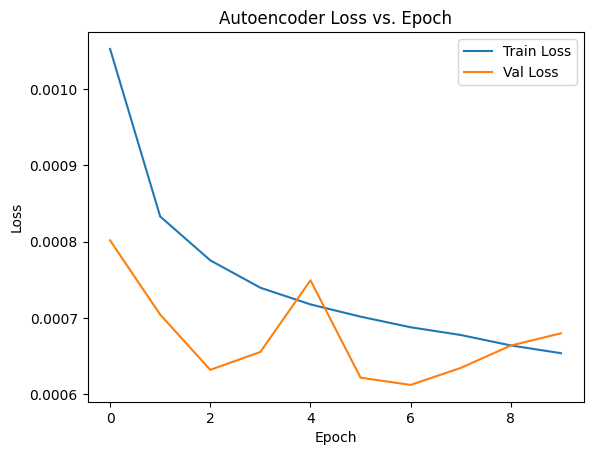

In [26]:
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Autoencoder Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

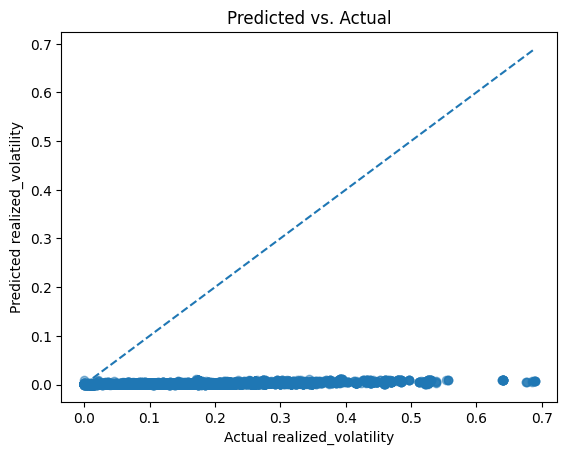

In [27]:
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual realized_volatility')
plt.ylabel('Predicted realized_volatility')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.show()

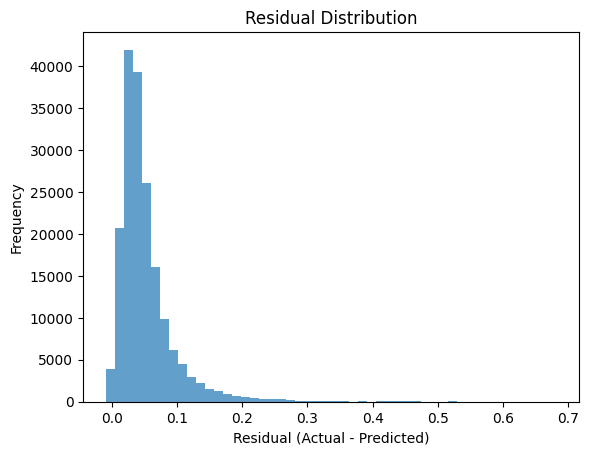

In [28]:
residuals = y_test - y_pred.flatten()

plt.figure()
plt.hist(residuals, bins=50, alpha=0.7)
plt.title('Residual Distribution')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()